# Springboard Intermediate Datascience - Capstone Project
## Housing price prediction based on web data
How accurate can our housing price prediction be, based on a few data scraped from the web ? In this project, I'll try using data I scraped on a belgian real-estate website (approx. 500 observations), from houses spread all around belgium. With this data, I'll assess whether I can obtain a fair model to predict housing price. <br>
I'll also try dealing with the data without too much thinking about how it can impact the model, then I'll do it with the help a of real-estate professionnal and assess whether I can obtain a better model or not.

#### Preliminary notes:
Here we work with annonced prices, but not saleprices. We'll therfore predict annonced prices and not saleprices. 
People often tend to ask for too much when they sell their house.

Many people like to negociate. Maybe the ideal model should propose a price based on the saleprice but not the annonced one. It should indicate the saleprice and give a price to annonce so that people can negociate (people like it and feel good when they feel like they get a deal).


# DATA WRANGLING

## Importing the data and cleaning

### Important Note: the following shows first what I did without and then with the real-estate expert's advice.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('immoweb_scraped_data.csv')

# display bigger figures in line
mpl.rcParams['figure.figsize'] = (10,10)
mpl.style.use('fivethirtyeight')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Columns: 110 entries, Address to Year of construction
dtypes: float64(21), object(89)
memory usage: 421.2+ KB


Scraping the data lead me to obtain a lot of different features (110), for not that many observations (490). Depending on the person who gave the information, the amount of features is very different from one observation to another. Let's have a look at the best-filled features (with the lower NaN rate).
<br><br>
Let's have a quick look at the dataframe:

In [3]:
is_count = df.count()
#let's keep only features with 75% filled values:
to_keep = is_count.index[is_count.values>(0.75*len(df))]
print('We initially had {0:1d} features, but we can now keep {1:1d} [75% filled].'.format(len(is_count.index),len(to_keep)))

We initially had 110 features, but we can now keep 29 [75% filled].


Still, we may have to clean some more because some features may not be relevant. Let's have a look:

In [4]:
to_keep = to_keep.tolist()
print(to_keep)

['Address', 'As built plan', 'As property tenant or owner, insure your real estate: fire, theft, water damage, storm, ...', 'Available as of', 'Bathrooms', 'Bedroom 1 area', 'Bedrooms', 'Building condition', 'Cadastral income', 'Double glazing', 'EPC - Energy consumption', 'Find the mortgage formula and a borrowing rate that suits you the best!', 'Heating', 'Inspection report of the electrical installation', 'Kitchen setup', 'Living room', 'Net floor area', 'Number of frontages', 'Planning permission obtained', 'Plot area', 'Possible priority purchase right', 'Proceedings for breach of planning regulations', 'Reference number of the EPC report', 'Requested sale price', 'Subdivision permit', 'Terrace', 'To ensure your payments and your family safety in case of early death, you can take a Decreasing life insurance.', 'Toilets', 'Year of construction']


In this list, we see "Living room", but not "Living room area" --> The area is more relevant to us and we'll therefore drop "Living room" (boolean) and add "Living room area"

In [5]:
to_keep.append('Living room area')
to_keep.remove('Living room')

Here are the other features we can remove: 'As built plan','As property tenant or owner, insure your real estate: fire, theft, water damage, storm, ...','Available as of','Find the mortgage formula and a borrowing rate that suits you the best!','Planning permission obtained','Possible priority purchase right','Proceedings for breach of planning regulations','Reference number of the EPC report'

<b>Note: </b>keeping features where I have too few observations will be difficult to manage and very uncertain (how should I fill nan's ?). I'd rather keep the features with a lot of observations for two reasons:
<ul>
  <li>People completed these information based on what is relevant to the buyer. I therefore expect these features to have a higher impact on the price;</li>
  <li>The more information I have, the better for my model</li>
</ul>

These can be removed because they either are not relevant, or most of the observations are "Not Specified".

In [6]:
list_remove = ['As built plan','As property tenant or owner, insure your real estate: fire, theft, water damage, storm, ...','Available as of','Find the mortgage formula and a borrowing rate that suits you the best!','Planning permission obtained','Possible priority purchase right','Proceedings for breach of planning regulations','Reference number of the EPC report','To ensure your payments and your family safety in case of early death, you can take a Decreasing life insurance.','Subdivision permit']
print("To remove: {0:1d}".format(len(list_remove)))
for ft in list_remove:
    if ft in to_keep:
        to_keep.remove(ft)
print("Kept: {0:1d}".format(len(to_keep)))

To remove: 10
Kept: 19


In [7]:
#Let's make a copy and keep a clean version of the dataframe at this point
df1 = df[to_keep].copy()

Let's now look at the different features and try to clean/fill the dataframe

In [8]:
df1.columns

Index(['Address', 'Bathrooms', 'Bedroom 1 area', 'Bedrooms',
       'Building condition', 'Cadastral income', 'Double glazing',
       'EPC - Energy consumption', 'Heating',
       'Inspection report of the electrical installation', 'Kitchen setup',
       'Net floor area', 'Number of frontages', 'Plot area',
       'Requested sale price', 'Terrace', 'Toilets', 'Year of construction',
       'Living room area'],
      dtype='object')

In [9]:
df1.head(3)

,Address,Bathrooms,Bedroom 1 area,Bedrooms,Building condition,Cadastral income,Double glazing,EPC - Energy consumption,Heating,Inspection report of the electrical installation,Kitchen setup,Net floor area,Number of frontages,Plot area,Requested sale price,Terrace,Toilets,Year of construction,Living room area
0,Tongersesteenweg 205 | 3770 - Riemst,1.0,18 m2,3.0,Good condition,€ 873,yes,380 kWh/m2,Fuel,"yes, conform",Semi-equipped,250 m2,4.0,"1,880 m2","€ 299,000",yes,2.0,1969.0,46 m2
1,Kerkstraat 122 | 2870 - Puurs,1.0,28 m2,3.0,To be renovated,"€ 1,110",yes,576 kWh/m2,Gas,"yes, not conform",Installed,338 m2,3.0,470 m2,"€ 239,000",yes,3.0,1965.0,73 m2
2,Avenue du Putdael 3 | 1150 - Woluwe-Sai...,5.0,26 m2,4.0,As new,"€ 4,858",yes,304 kWh/m2,Gas,"yes, conform",USA Hyper-equipped,335 m2,4.0,794 m2,"€ 1,590,000",yes,5.0,1950.0,32 m2


We can clean numeric data and scale text data for some features. We'll do this for:
<ul>
  <li>Price</li>
  <li>Plot area</li>
  <li>Bathrooms</li>
  <li>Bedroom 1 area</li>
  <li>Bedrooms</li>
  <li>Building condition</li>
  <li>Cadastral income</li>
  <li>Double glazing</li>
  <li>EPC - Energy consumption</li>
  <li>Heating --> OneHotEncode ?</li>
  <li>Inspection report of the electrical installation</li>
  <li>Kitchen setup --> OneHoteEncode ?</li>
  <li>Living room</li>
  <li>Net floor area</li>
  <li>Number of frontages</li>
  <li>Terrace</li>
  <li>Toilets</li>
  <li>Year of construction</li>

</ul>


Many features can be treated the same way:

In [10]:
#Listing features for which 0's can be repalced with median (to me):
zero_median = ['Price','Plot area','Bathrooms','Bedroom 1 area','Bedrooms','Cadastral income','EPC - Energy consumption',\
              'Living room area','Net floor area','Number of frontages','Toilets','Year of construction']

But let's first clean each feature separately:

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 19 columns):
Address                                             490 non-null object
Bathrooms                                           463 non-null float64
Bedroom 1 area                                      368 non-null object
Bedrooms                                            489 non-null float64
Building condition                                  467 non-null object
Cadastral income                                    452 non-null object
Double glazing                                      383 non-null object
EPC - Energy consumption                            472 non-null object
Heating                                             451 non-null object
Inspection report of the electrical installation    403 non-null object
Kitchen setup                                       429 non-null object
Net floor area                                      482 non-null object
Number of frontages          

All non-float features that should be numeric need to be cleaned ! <br>
Cadastral income, EPC, Living room area, Net floor area, Sale price, Plot Area, Bedroom 1 area, Toilets <br>
We'll first fill all missing values (Nan bu also others) with zeros. Then, we'll be able to easily replace all the zeros with appropriate numerics.

#### Price:

In [12]:
#What does the price look like ?
df1['Requested sale price'].sample(5)

375      € 230,000
168      € 229,000
58       € 265,000
54     € 1,395,000
150      € 385,000
Name: Requested sale price, dtype: object

We need to get rid of the € sign, as well as of the commas.

In [13]:
#no need for data if no house price !! 
df1 =df1[pd.notnull(df['Requested sale price'])].copy()
df1['Price'] = [int(x.strip("€").strip().replace(',','')) for x in df1['Requested sale price']]
df1.drop('Requested sale price',axis=1)
df1['Price'].sample(5)

14     895000
452    495000
415    127000
337    115000
62     385000
Name: Price, dtype: int64

Any missing values ?

In [14]:
df1['Price'].isnull().sum()

0

We have no missing values for Price !<br>
Any 0's ?

In [15]:
sum(df1['Price']==0)

0

In [16]:
#Remove requested sale price column:
df1.drop('Requested sale price', axis=1, inplace=True)

#### Plot area:

In [17]:
#What does the plot area look like ?
df1['Plot area'].sample(5)

474      524 m2
116      350 m2
393      709 m2
129    1,127 m2
357    1,110 m2
Name: Plot area, dtype: object

It is given with commas and "m2" at the end. Let's make it an integer.

In [18]:
#If NaN, then place '0 m2'
df1[['Plot area']] = df1[['Plot area']].fillna('0 m2')
df1['Plot area'] = [int(y.replace('m2','').strip().replace(',','')) for y in df1['Plot area']]
df1['Plot area'].sample(5)

252     235
236     491
466    3110
414     400
445     100
Name: Plot area, dtype: int64

In [19]:
#Missing values ?
df1['Plot area'].isnull().sum()

0

<br>
(Bathrooms is of type float64 and no cleaning is required.)
#### Bedroom 1 area:

In [20]:
df1['Bedroom 1 area'].sample(3)

1      28 m2
35     30 m2
386    17 m2
Name: Bedroom 1 area, dtype: object

"m²" needs to be removed so that we have a type int.

In [21]:
df1[['Bedroom 1 area']] = df1[['Bedroom 1 area']].fillna('0 m2')
df1['Bedroom 1 area'] = [int(y.replace('m2','').strip().replace(',','')) for y in df1['Bedroom 1 area']]
df1['Bedroom 1 area'].sample(3)

200    18
66     13
15     15
Name: Bedroom 1 area, dtype: int64

#### Net Floor Area:

In [22]:
df1['Net floor area'].sample(3)

433    168 m2
190    110 m2
236    120 m2
Name: Net floor area, dtype: object

In [23]:
df1[['Net floor area']] = df1[['Net floor area']].fillna('0 m2')
df1['Net floor area'] = [int(y.replace('m2','').strip().replace(',','')) for y in df1['Net floor area']]
df1['Net floor area'].sample(3)

223    895
100    620
225    250
Name: Net floor area, dtype: int64

#### Living room area:

In [24]:
df1['Living room area'].sample(3)

330    43 m2
458    40 m2
20     75 m2
Name: Living room area, dtype: object

In [25]:
df1[['Living room area']] = df1[['Living room area']].fillna('0 m2')
df1['Living room area'] = [int(y.replace('m2','').strip().replace(',','')) for y in df1['Living room area']]
df1['Living room area'].sample(3)

269    42
394     0
338    13
Name: Living room area, dtype: int64

#### EPC - Energy consumption:

In [26]:
df1['EPC - Energy consumption'].sample(3)

73     496 kWh/m2
166    154 kWh/m2
154    216 kWh/m2
Name: EPC - Energy consumption, dtype: object

In [27]:
df1['EPC - Energy consumption'].replace('not specified',np.nan,inplace=True) #some observations are "not specified". Replaced by NaN
df1[['EPC - Energy consumption']] = df1[['EPC - Energy consumption']].fillna('0 kWh/m2')
df1['EPC - Energy consumption'] = [int(y.replace('kWh/m2','').strip().replace(',','')) for y in df1['EPC - Energy consumption']]
df1['EPC - Energy consumption'].sample(3)

14     557
406    753
303    676
Name: EPC - Energy consumption, dtype: int64

#### Cadastral income:

In [28]:
df1['Cadastral income'].sample(3)

428      € 480
240        NaN
282    € 5,515
Name: Cadastral income, dtype: object

In [29]:
df1['Cadastral income'] = df1['Cadastral income'].fillna('0')
df1['Cadastral income'] = [int(x.replace('€','').strip().replace(',','')) for x in df1['Cadastral income']]
df1['Cadastral income'].sample(3)

395     761
148    7229
339     436
Name: Cadastral income, dtype: int64

#### Bathrooms : 
As seen previously: Bathrooms 463 non-null float64<br>
We only need to fill missing values for now.

In [30]:
df1['Bathrooms'] = df1['Bathrooms'].fillna('0')

### Filling all the zeroes:
We'll replace all zeros with the median for each column. It is not a problem here as we only kept features with a few missing values.
We can do this with Bedrooms, Number of frontages, Toilets, Year of construction.

In [31]:
#first let's make sure all Nan's have been converted to zeros in these columns: 
numerics = ['Price','Plot area','Cadastral income','EPC - Energy consumption','Living room area','Net floor area',\
            'Bedroom 1 area','Toilets','Bedrooms','Number of frontages','Year of construction','Bathrooms']
for ft in  numerics:
    df1[ft]=df1[ft].astype(float)
    if df1[ft].isnull().sum() != 0: #if we have some Nans
        df1[ft].fillna(0,inplace=True)
    df1[ft][df1[ft]==0] = np.median(df1[ft])

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 19 columns):
Address                                             488 non-null object
Bathrooms                                           488 non-null float64
Bedroom 1 area                                      488 non-null float64
Bedrooms                                            488 non-null float64
Building condition                                  465 non-null object
Cadastral income                                    488 non-null float64
Double glazing                                      381 non-null object
EPC - Energy consumption                            488 non-null float64
Heating                                             449 non-null object
Inspection report of the electrical installation    401 non-null object
Kitchen setup                                       427 non-null object
Net floor area                                      488 non-null float64
Number of frontages      

All cleaned features now have 488 non-null values.

In [33]:
#Function to plot count of features:
def display_count(df,feature):
    from collections import Counter
    count = Counter(df[feature])
    df_count = pd.DataFrame.from_dict(count, orient='index')
    df_count.plot(kind='bar')
    plt.title('Count of ' + feature)
    plt.show()

#### Building Condition

In [34]:
df1['Building condition'].isnull().sum()

23

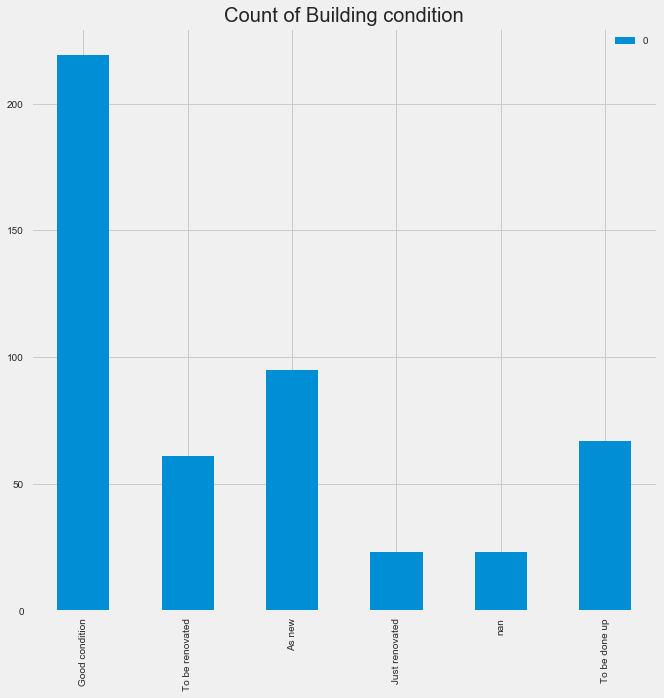

In [35]:
display_count(df1,'Building condition')

Let's consider Nan to be in good condition, as it is the most common state.
But house condition is subjective. Maybe it would be better to not consider this as an owner will probably set it at his advantage ? I don't know..

In [36]:
df1['Building condition'] = df1['Building condition'].fillna('Good condition')

In [37]:
df1['Building condition'].isnull().sum()

0

#### Double Glazing

Maybe gthis criteria is correlated to energy consumption, with heating. Indeed, based on heating an glazing, the consumption will increase/decrease accordingly.

In [38]:
df1['Double glazing'].isnull().sum()

107

This feature either gives YES or Nan --> As double glazing is really important for the buyer, I expect every seller to notify it if there is (it is not something you forget to mention). Therefore all blanks represent the 'No' answer.

In [39]:
df1['Double glazing'] = df1['Double glazing'].fillna('no')

In [40]:
df1['Double glazing'].isnull().sum()

0

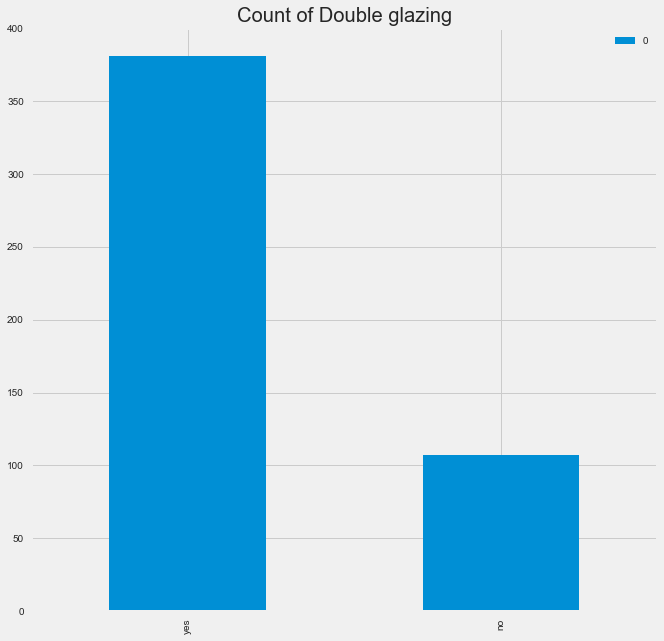

In [41]:
display_count(df1,'Double glazing')

#### Kitchen Setup

Transofr into boolean --> Equipped or not.

Equipped = Installed, USA Hyper equipped, USA installed, Hyper-equipped
Non-equipped = Semi-equipped, Uninstalled, USA semi-equipped

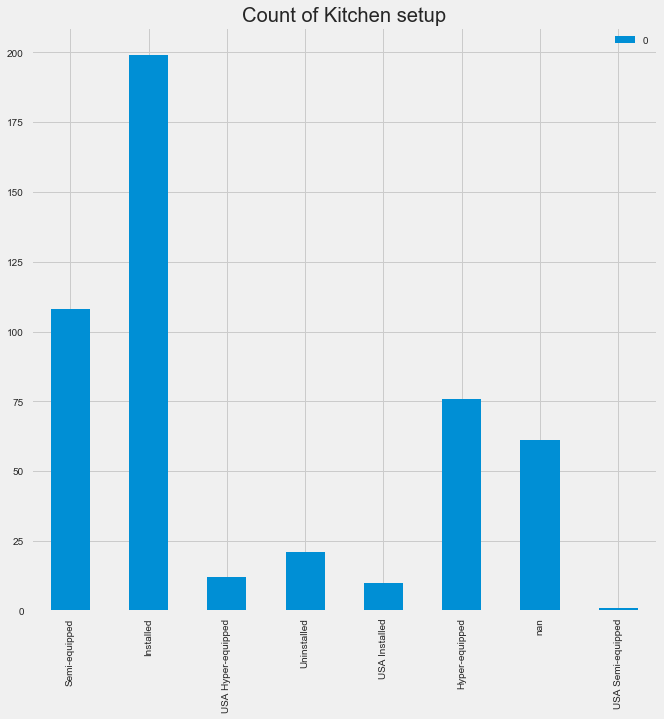

In [42]:
display_count(df1,'Kitchen setup')

"Installed" seems to be default for the houses. Let's fill nans with "Installed". 

In [43]:
df1['Kitchen setup'] = df1['Kitchen setup'].fillna('Installed')

#### Heating: 

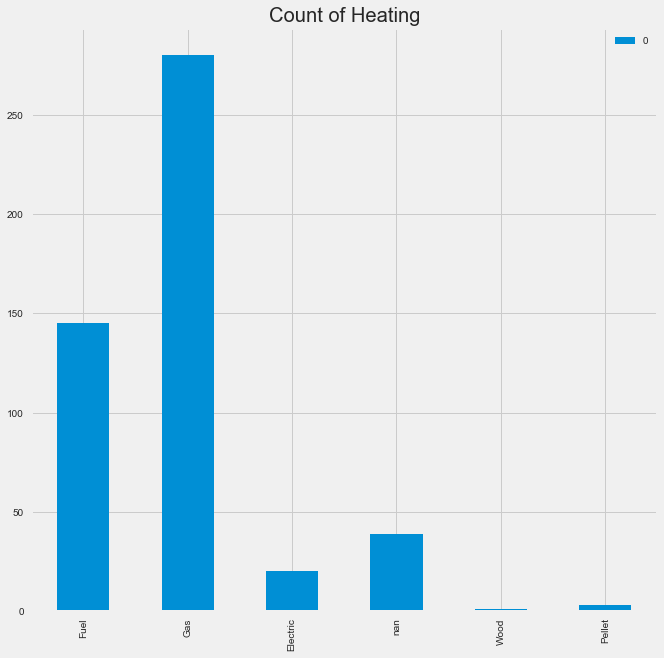

In [44]:
display_count(df1,'Heating')

Heating is mosly gas --> Let's fill the few Nan's with 'Gas':

In [45]:
df1['Heating'] = df1['Heating'].fillna('Gas')

#### Inspection report of the electrical installation

As for double glazing, we expect owners with a conform electrical installation to mention it as it is a value adder for the house. We'll consider all Nan's to be 'no'.

In [46]:
df1['Inspection report of the electrical installation'] = df1['Inspection report of the electrical installation'].fillna('no')

#### Terrace
Same as above.

In [47]:
df1['Terrace'] = df1['Terrace'].fillna('no')

In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 19 columns):
Address                                             488 non-null object
Bathrooms                                           488 non-null float64
Bedroom 1 area                                      488 non-null float64
Bedrooms                                            488 non-null float64
Building condition                                  488 non-null object
Cadastral income                                    488 non-null float64
Double glazing                                      488 non-null object
EPC - Energy consumption                            488 non-null float64
Heating                                             488 non-null object
Inspection report of the electrical installation    488 non-null object
Kitchen setup                                       488 non-null object
Net floor area                                      488 non-null float64
Number of frontages      

### Encoding : 
Now that we have our dataframe completed, let's work a bit more on the non-numeric entries so that we can use these for the model.

In [49]:
df2 = df1.copy()

In [50]:
df2 = pd.get_dummies(df2,columns=['Building condition','Double glazing','Kitchen setup','Heating','Terrace','Inspection report of the electrical installation'], prefix=['condition','double_glazing','kitchen','heating','terrace','elec_report'])

In [51]:
df2.head()

,Address,Bathrooms,Bedroom 1 area,Bedrooms,Cadastral income,EPC - Energy consumption,Net floor area,Number of frontages,Plot area,Toilets,...,heating_Electric,heating_Fuel,heating_Gas,heating_Pellet,heating_Wood,terrace_no,terrace_yes,elec_report_no,"elec_report_yes, conform","elec_report_yes, not conform"
0,Tongersesteenweg 205 | 3770 - Riemst,1.0,18.0,3.0,873.0,380.0,250.0,4.0,1880.0,2.0,...,0,1,0,0,0,0,1,0,1,0
1,Kerkstraat 122 | 2870 - Puurs,1.0,28.0,3.0,1110.0,576.0,338.0,3.0,470.0,3.0,...,0,0,1,0,0,0,1,0,0,1
2,Avenue du Putdael 3 | 1150 - Woluwe-Sai...,5.0,26.0,4.0,4858.0,304.0,335.0,4.0,794.0,5.0,...,0,0,1,0,0,0,1,0,1,0
3,Elie Aubinaustraat 29 | 1932 - Zaventem,1.0,14.0,5.0,899.0,687.0,189.0,3.0,1220.0,1.0,...,0,0,1,0,0,1,0,0,0,1
4,Dendermondsesteenweg 20 | 2830 - Willeb...,1.0,13.0,2.0,255.0,164.0,120.0,2.0,115.0,2.0,...,0,0,1,0,0,0,1,0,1,0


#### Taking care of the location:
Let's first try a model without longitude and latitude. We'll then see if we can improve our model with precise location.

In [52]:
df1['Address'] = [y.replace('|','').strip() for y in df1['Address']]
df1['Address']=[' '.join(y.split()) for y in df1['Address']]
df1['Address']=[y.replace('Ask for the exact address','') for y in df1['Address']]

In [53]:
# #Address --> Lat. Long.

# import os
# from geopy import geocoders
# from geopy.geocoders import GoogleV3

# cpt=1

# API_KEY = os.getenv("API1234")
# g = GoogleV3(API_KEY)

# loc_coordinates = []
# loc_address = []
# for address in df1.Address:
#     try:
#         inputAddress = address
#         location = g.geocode(inputAddress)
#         loc_coordinates.append((location.latitude, location.longitude))
#         loc_address.append(inputAddress)
#     except Exception as e:
#         print('{0:1d} : '.format(cpt), address, e)
#         cpt+=1

# df_geocodes = pd.DataFrame({'coordinate':loc_coordinates,'address':loc_address})

As we have very few observations spread all around belgium, let's drop this feature.

In [54]:
df1.drop('Address',axis=1,inplace=True)

## Notes from the real-estate expert:

<ul>
  <li>EPC : in the following, we'll also consider heating and glazing. Altogether, these 3 variables are somehow redundant. The EPC score is calculated based on - among other things - galzing and heating. For our expert's dataset (let's call it this way), we'll drop this variable.</li>
  <li>Cadastral income: maybe we should not consider cadastral income in the analysis, as it is a consequence of the house price. But we could use it to check whether our tool worked properly. If the difference is too big between house price estimated with cadastral income and house price estimated with our tool, then we can display some text saying that there is a mismatch. If it's quite concording, it can increase confidence in the model.</li>
  <li>Year of construct : makes no sense as a really old house can be renovated and therefore be super great. it is not advised to take this into account !</li>
  <li>Indoor parking spaces: this feature should be kept as it is really important to people living downtown. All missing values can be replaced with zero as we can expect the seller to mention it if there is one.</li>
  <li>Kitchen setup: this criteria can be seen as boolean (equipped or not). Nan's are not equipped.</li>
<li>Heating: this variable is almost binary. Gas and fuel are nice to have, but having other forms of heating has no added value when you decide to buy a house. For example, buying electric heaters is cheap but costs a lot to use.</li>
<li>Toilets/bathrooms: every house has at least one toilet/bathroom. This feature could be seen as a boolen where having multiple toilets/bathrooms is (1) and having one is standard (0).</li>
</ul>

<b>Additional notes:</b> 
<ul>
    <li>Here we work with annonced prices and not saleprices. We'll therefore predict annonced prices. This information is to interpret carefully as people often tend to ask for too much for their house. Furthermore, buyers like to negociate and feel like they make a good deal. A good model should give the saleprice and indicate a good price to annonce so that the required saleprice is reached.</li>
</ul>

<br><br>

### Expert's dataset ["_e"]
Let's now take all these advices into account, and build our expert's dataset.

In [55]:
df1_e = df1.copy()

We need to clean differently for Kitchen setup, Heating, Toilets, Bathrooms. Building condition, EPC Energy consumption, cadastral income, year of construct can be dropped.

In [56]:
#Replacing already cleaning features with initial data + adding parking spaces
df1_e['Kitchen setup'] = df['Kitchen setup']
df1_e['Heating'] = df['Heating']
df1_e['Toilets']= df['Toilets']
df1_e['Bathrooms']= df['Bathrooms']
df1_e['Indoor parkings'] = df['Indoor parking spaces']

#Dropping features
df1_e.drop('EPC - Energy consumption',axis=1,inplace=True)
df1_e.drop('Cadastral income',axis=1,inplace=True)
df1_e.drop('Year of construction',axis=1,inplace=True)
df1_e.drop('Building condition',axis=1,inplace=True)
df1_e.drop('Inspection report of the electrical installation',axis=1,inplace=True)

In [57]:
df1_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 14 columns):
Bathrooms              461 non-null float64
Bedroom 1 area         488 non-null float64
Bedrooms               488 non-null float64
Double glazing         488 non-null object
Heating                449 non-null object
Kitchen setup          427 non-null object
Net floor area         488 non-null float64
Number of frontages    488 non-null float64
Plot area              488 non-null float64
Terrace                488 non-null object
Toilets                458 non-null float64
Living room area       488 non-null float64
Price                  488 non-null float64
Indoor parkings        320 non-null float64
dtypes: float64(10), object(4)
memory usage: 57.2+ KB


We still have 15 features. Now time for cleaning, according to above advices.
#### Toilets and Bathrooms
One is standard (0), multiple is a value adder (1).

In [58]:
#Filling missing values with 1, as we consider no house has been built without capability for a bathroom/Toilet
df1_e['Toilets'] = df1_e['Toilets'].astype(str).astype(float)
df1_e['Bathrooms'] = df1_e['Bathrooms'].astype(str).astype(float)

df1_e['Toilets'] = df1_e['Toilets'].fillna(float('1'))
df1_e['Bathrooms'] = df1_e['Bathrooms'].fillna(float('1'))

#All 1's --> 0. All >1 --> 1
df1_e['Toilets'][df1_e['Toilets']==1] = float(0) 
df1_e['Toilets'][df1_e['Toilets']>1] = float(1) 

df1_e['Bathrooms'][df1_e['Bathrooms']==1] = float(0) 
df1_e['Bathrooms'][df1_e['Bathrooms']>1] = float(1) 

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipyke

In [59]:
df1_e['Bathrooms'].sample(4)

318    0.0
345    0.0
398    0.0
23     1.0
Name: Bathrooms, dtype: float64

#### Heating
Gas and fuel = 1. Others = 0.

In [60]:
#Not specified = 0
df1_e['Heating']=df1_e['Heating'].fillna(0)

df1_e['Heating'] = [1 if h in ['Gas','Fuel'] else 0 for h in df1_e['Heating']]

df1_e['Heating'].sample(3)

104    1
429    1
299    1
Name: Heating, dtype: int64

#### Kitchen setup
Is the kitchen equipped (1) or not ?

In [61]:
#Not specified = 0
df1_e['Kitchen setup']=df1_e['Kitchen setup'].fillna(0)

df1_e['Kitchen setup'] = [1 if k in ['Installed','USA Hyper-equipped','USA Installed','Hyper-equipped'] else 0 \
                          for k in df1_e['Kitchen setup']]

In [62]:
df1_e['Kitchen setup'].sample(5)

283    1
241    1
331    1
450    1
197    1
Name: Kitchen setup, dtype: int64

#### Indoor Parking Spaces
This is a really important feature for people living in cities especially. We'll have three stages: not having indoor parking spaces, having one and aving multiple ones.

In [63]:
df1_e['Indoor parkings']=df1_e['Indoor parkings'].fillna(0)
df1_e['Indoor parkings']=[2 if p > 1 else p for p in df1_e['Indoor parkings']]

In [64]:
df1_e['Indoor parkings'].sample(5)

486    1.0
129    1.0
128    0.0
63     0.0
26     1.0
Name: Indoor parkings, dtype: float64

In [65]:
df1_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 14 columns):
Bathrooms              488 non-null float64
Bedroom 1 area         488 non-null float64
Bedrooms               488 non-null float64
Double glazing         488 non-null object
Heating                488 non-null int64
Kitchen setup          488 non-null int64
Net floor area         488 non-null float64
Number of frontages    488 non-null float64
Plot area              488 non-null float64
Terrace                488 non-null object
Toilets                488 non-null float64
Living room area       488 non-null float64
Price                  488 non-null float64
Indoor parkings        488 non-null float64
dtypes: float64(10), int64(2), object(2)
memory usage: 57.2+ KB


In [66]:
#Let's keep a clean dataset as backup and use df2_e (as we'll use df2 as well)
df2_e = df1_e.copy()

In [67]:
df2_e = pd.get_dummies(df2_e,columns=['Double glazing','Terrace'], \
                       prefix=['double_glazing','terrace'])

In [68]:
df2_e.head(5)

,Bathrooms,Bedroom 1 area,Bedrooms,Heating,Kitchen setup,Net floor area,Number of frontages,Plot area,Toilets,Living room area,Price,Indoor parkings,double_glazing_no,double_glazing_yes,terrace_no,terrace_yes
0,0.0,18.0,3.0,1,0,250.0,4.0,1880.0,1.0,46.0,299000.0,2.0,0,1,0,1
1,0.0,28.0,3.0,1,1,338.0,3.0,470.0,1.0,73.0,239000.0,1.0,0,1,0,1
2,1.0,26.0,4.0,1,1,335.0,4.0,794.0,1.0,32.0,1590000.0,2.0,0,1,0,1
3,0.0,14.0,5.0,1,0,189.0,3.0,1220.0,0.0,14.0,350000.0,1.0,1,0,1,0
4,0.0,13.0,2.0,1,1,120.0,2.0,115.0,1.0,24.0,195000.0,0.0,0,1,0,1


### Let's now have a look at the data and remove eventual outliers

In [69]:
#Histogram of Price:

from scipy import stats
from scipy.stats import norm

def normality_check(df,feature):
    sns.distplot(df[feature] , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[feature])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(str(feature) + ' distribution')

    fig = plt.figure()
    res = stats.probplot(df[feature], plot=plt)
    plt.show()

    print("Skewness: %f" % df[feature].skew())
    print("Kurtosis: %f" % df[feature].kurt())


 mu = 450178.79 and sigma = 427155.88



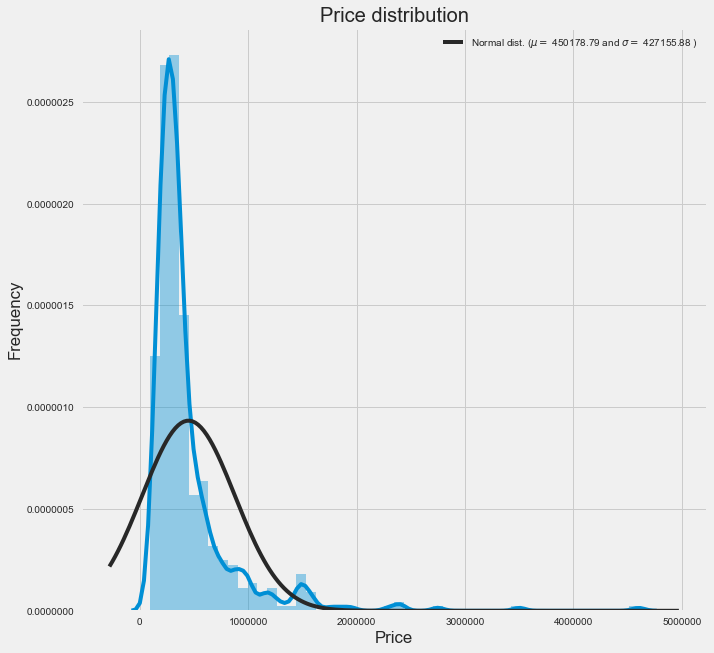

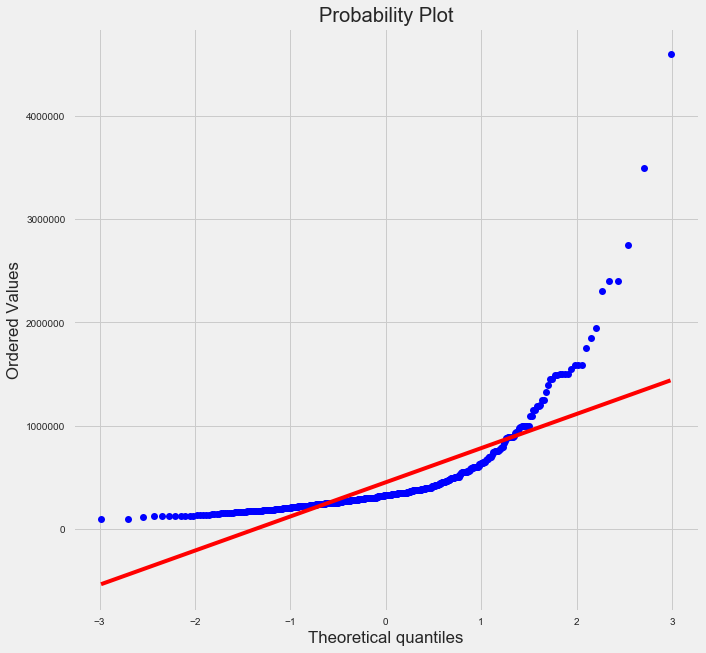

Skewness: 4.244211
Kurtosis: 27.153788


In [70]:
normality_check(df2,'Price')

The histogram is clear, our distribution is significantly different from normal distribution with same median and stdev.
Also, we can see on the probability plot that we do not have a normal distribution (normal is in red, ours in blue). <br>
A normal distribution has a Skewness of zero --> Here we have 4.24 which confirms it is not normal. The high kurtosis tells us we have a lot of weight in the tails (combined). <br>
<b>For now:</b> let's keep the data as it is. Later, we'll try to make it more normal to see if we can improve our results !